# this is a demonstration to show how FilterDCA is working

- take plmDCA results and transform them into a matrix
 - option: plot dca matrix
- apply the filters on the dca matrix: create Pattern score matrix
 - option: plot Pattern score matrix


### Prediction
- use DCA score and Pattern score to determine the probability of contact for each (i,j)
 - option: plot probability matrix
 


In [12]:
import pandas
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pickle
import sklearn

In [4]:
def create_dca_matrix(name,len_d1,len_d2,option=True):
    df=pandas.read_csv(name,sep='\t',header=None )
    df=df.sort_values([0,1])
    df=df[df[0]<len_d1+1]
    df=df[df[1]>len_d1]
    matrix=np.array(df[2]).reshape(len_d1,len_d2)
    if option ==True :
        plt.imshow(matrix)
    return matrix

def compute_matrix_result_for_one_filter(matrice_dca,mat_f):
    """
    Giving the dca matrix and a filter
    compute the correlation matrix
    """
    v=len(mat_f)
    v=v//2
    (len_domain1,len_domain2)=matrice_dca.shape
    matrix_result=matrice_dca.copy()
    matrix_best_f=np.zeros((len_domain1,len_domain2))
    for indice_1 in range(0,len_domain1):
        for indice_2 in  range(0,len_domain2):
            correlation=0.0
            i_centre,j_centre= min( indice_1,v) ,min(indice_2,v)
            sous_matrix=matrice_dca[max(0,indice_1-v):indice_1+v+1,max(0,indice_2-v):indice_2+v+1]
            mat_f[len(mat_f)//2,len(mat_f)//2]=np.nan
            m_f=mat_f[ max(v-indice_1,0):min(v*2+1,len_domain1-indice_1+v) ,max(v-indice_2,0):min(v*2+1,len_domain2+v-indice_2)]
            indic_flatt=m_f.shape[1]*i_centre+j_centre
            if matrice_dca[indice_1,indice_2]!=sous_matrix.flatten()[indic_flatt] :
                print('Problem')
            ## remove the central value 
            m_f=np.delete(m_f.flatten(),indic_flatt)
            sous_matrix=np.delete(sous_matrix.flatten(),indic_flatt)
            # print scipy.stats.pearsonr(sous_matrix,m_f)[0]
            if np.sum(sous_matrix[0]==sous_matrix )!=len(sous_matrix):
                correlation=scipy.stats.pearsonr(sous_matrix,m_f)[0]
            matrix_result[indice_1,indice_2]=correlation
    return matrix_result

def pattern_computation(dca_matrix,liste_mat_filtre):
    shape = dca_matrix.shape
    index = pandas.MultiIndex.from_product([range(s)for s in shape], names=list('ij'))
    df = pandas.DataFrame({'dca': dca_matrix.flatten()}, index=index).reset_index()
    for num_mat,filter in enumerate(liste_mat_filtre) :
        A=compute_matrix_result_for_one_filter(dca_matrix,filter)
        df['resul_{}_{}'.format(v,num_mat)]=A.flatten() ## matrix result
    df['best_corr {}'.format(v)]=df[['resul_{}_{}'.format(v,num_mat) for num_mat in range(len(liste_mat_filtre))]].max(axis=1)
    df['best_f {}'.format(v)]=df[['resul_{}_{}'.format(v,num_mat) for num_mat in range(len(liste_mat_filtre))]].idxmax(axis=1)
    return df


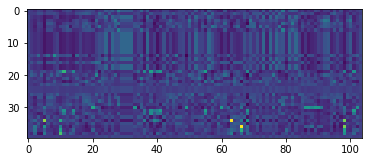

In [11]:
# name='combined_MSA_ddi_1_PF10417_PF00578_result'
name='combined_MSA_ddi_3_PF10417_PF00085_result'
lend1,lend2=40,104
dca_matrix=create_dca_matrix(name,lend1,lend2,option=True)

In [10]:
## load the 6 filters of the selected size
v=69
liste_mat_filtre=list(np.load('maps/{}/list_mat.npy'.format(v)))

FileNotFoundError: ignored

In [ ]:
## Apply each of the 6 filters on the dca matrix
df=pattern_computation(dca_matrix,liste_mat_filtre)

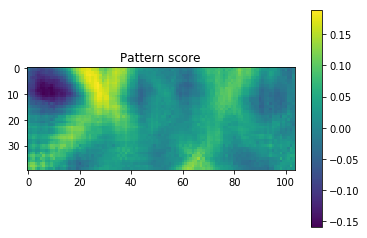

In [ ]:
correlation_matrix=np.array(df['best_corr {}'.format(v)]).reshape((dca_matrix.shape))
plt.imshow(correlation_matrix)
plt.title('Pattern score')
plt.colorbar()

## Compute the prediction

In [ ]:
# Load the classifiar and the min and max values for the pattern score 
size_meff='big'
clf = pickle.load(open('classifier/{}-{}-linear-clf.sav'.format(v,size_meff) , "rb"),encoding='latin1')  
min_c,max_c=np.loadtxt('classifier/min_max_{}_{}'.format(v,size_meff))

In [ ]:
# We normalize the 'best corr' variable
df['corr {}'.format(v)]=(df['best_corr {}'.format(v)] - min_c) / (max_c - min_c)

In [ ]:
column=['dca','corr {}'.format(v)]
X=np.array(df[column])
probability= clf.predict_proba(X)[:,1]
df['proba contact']=probability

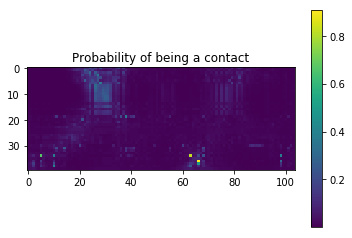

In [ ]:
plt.imshow(probability.reshape(dca_matrix.shape))
plt.title('Probability of being a contact')
plt.colorbar()

Text(0.5, 1.0, 'Predicted contact map')

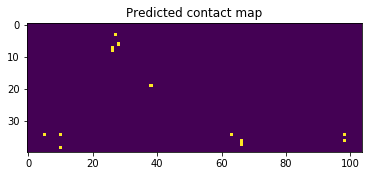

In [ ]:
contact=probability>0.3
plt.imshow(contact.reshape(dca_matrix.shape))
plt.title('Predicted contact map')

In [ ]:
## to save results
df.to_csv('results.dat',index=False)